# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [26]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## Read data 

In [28]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

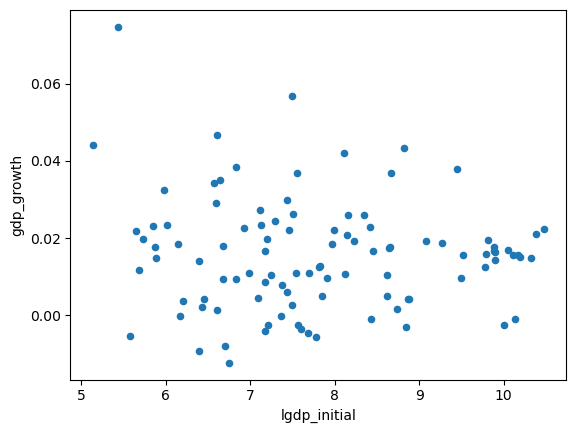

In [29]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

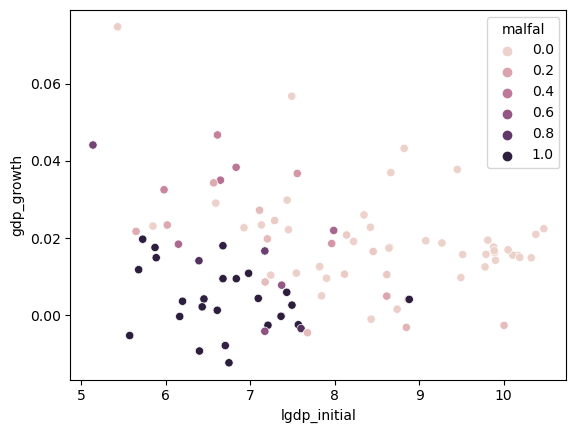

In [30]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [31]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage'] # Diseases
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

# Variables we use
# Institutions, geography, religion, danger (health), resources, education, pop growth

# Code job for Lucas
# Use variables choosen
# Graph Lasso with different penalty levels
# Lasso with CV, BRT and BCCH at difference penalty levels like in week 4 exercise
# Use BRT and BCCH optimal penalty level and use dobbel lasso and post dobbelt lasso.



In [32]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [33]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'gdp_pc_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','gdp_pc_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 1.59145681e+00]
 [-3.92054026e-06]]


# Adding more controls

In [34]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y
#print(betas)

In [35]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [36]:
from datetime import datetime

# ---- configuration ----
id_col = 'code'
cols_to_check = ['gdp_growth', 'lgdp_initial']
continent_cols = ['africa', 'americas', 'asia', 'europe', 'oceania'] # Europa is irrelevant, as it is reference dummy
report_path = 'data_cleaning_report.txt'

# ---- identify rows to remove / keep ----
missing_mask = dat[cols_to_check].isnull().any(axis=1)
removed = dat.loc[missing_mask].copy()
kept = dat.loc[~missing_mask].copy()

# ---- helper: decode continent from dummies ----
def resolve_continent(row):
    active = [c for c in continent_cols if row.get(c, 0) == 1]
    if len(active) == 1:
        return active[0].capitalize()
    elif len(active) == 0:
        return "Unknown"
    else:
        return "Multiple"

removed['continent'] = removed.apply(resolve_continent, axis=1)
kept['continent']   = kept.apply(resolve_continent, axis=1)

# (optional) which GDP columns were missing for removed
removed['missing_in'] = dat.loc[missing_mask, cols_to_check].isnull().apply(
    lambda r: ', '.join([c for c, v in r.items() if v]), axis=1
)

# ---- completeness table for kept countries, for "other variables" ----
exclude = set([id_col] + cols_to_check + continent_cols)
other_vars = [c for c in dat.columns if c not in exclude]

non_missing_counts = kept[other_vars].notnull().sum().rename('non_missing')
missing_counts = (len(kept) - non_missing_counts).rename('missing')
completeness = ((non_missing_counts / len(kept)) * 100).round(1).rename('complete_%')

completeness_table = pd.concat([non_missing_counts, missing_counts, completeness], axis=1)\
                       .sort_index()

# ---- build the report text ----
lines = []
lines.append("DATA CLEANING REPORT")
lines.append(f"Generated: {datetime.now().isoformat(timespec='seconds')}")
lines.append("")
lines.append(f"Total rows before cleaning: {len(dat)}")
lines.append(f"Rows removed (missing in {', '.join(cols_to_check)}): {len(removed)}")
lines.append(f"Rows kept (complete in those columns): {len(kept)}")
lines.append("")

# Removed list
lines.append("=== REMOVED COUNTRIES ===")
if removed.empty:
    lines.append("(none)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(removed[[id_col, 'continent', 'missing_in']].sort_values([ 'continent', id_col]).to_string(index=False))
lines.append("")

# Kept list
lines.append("=== KEPT COUNTRIES ===")
if kept.empty:
    lines.append("(none)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(kept[[id_col, 'continent']].sort_values([ 'continent', id_col]).to_string(index=False))
lines.append("")

# Summary by continent
lines.append("=== SUMMARY BY CONTINENT ===")
summary = pd.DataFrame({
    'removed': removed['continent'].value_counts(),
    'kept': kept['continent'].value_counts()
}).fillna(0).astype(int).sort_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    lines.append(summary.to_string())
lines.append("")

# Completeness table
lines.append("=== COMPLETENESS FOR KEPT COUNTRIES (OTHER VARIABLES) ===")
lines.append(f"(Variables excluded from this table: {', '.join(sorted(exclude))})")
if len(other_vars) == 0:
    lines.append("(no other variables found)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(completeness_table.to_string())

# ---- write file ----
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("\n".join(lines))

print(f"Report written to: {report_path}")


Report written to: data_cleaning_report.txt


# Testcode from Week 4 Lasso

In [37]:
# Keep only interesting variables
# Combining all variables we want to use
vs = []
vs.extend(vv_all['institutions'])  # Institutional variables
vs.extend(vv_all['geography'])     # Geographic variables
vs.extend(vv_all['religion'])      # Religious variables
vs.extend(vv_all['danger'])        # Health/disease variables
vs.extend(vv_all['resources'])     # Natural resource variables
vs.extend(vv_educ)
vs.extend(['pdiv'])                 # Genetic diversity variables
vs.extend(['pop_growth'])          # Population growth
vs.extend(['gdp_initial'])        # Log gdp initial


# Add our main variables of interest
main_var = ['lgdp_initial']
all_vars = main_var + vs

# Only remove countries with missing values in our chosen variables
complete_cases = dat[all_vars].notnull().all(axis=1)
kept = dat[complete_cases].copy()


# Prepare data for Lasso
y = kept['gdp_growth'].values.reshape((-1,1)) * 100.0  # Convert to percentage
X = kept[all_vars].values       # All variables except the dependent
d = kept['lgdp_initial'].values # Our beta variable

Xnames = list(kept[['lgdp_initial'] + vs].columns)

# Print dimensions of our matrices
print(f'X matrix shape: {X.shape}')
print(f'y vector shape: {y.shape}')

# Display number of regressors
#print("The number of regressors in Z is {}".format(Z.shape[1]))

# Verify no missing values remain in our variables of interest
print("\nMissing values after filtering:")
print(kept[all_vars].isnull().sum())

X matrix shape: (74, 43)
y vector shape: (74, 1)

Missing values after filtering:
lgdp_initial    0
marketref       0
dem             0
demCGV          0
demBMR          0
demreg          0
tropicar        0
distr           0
distcr          0
distc           0
suitavg         0
temp            0
suitgini        0
elevavg         0
elevstd         0
kgatr           0
precip          0
area            0
abslat          0
cenlong         0
area_ar         0
rough           0
landlock        0
africa          0
asia            0
oceania         0
americas        0
pprotest        0
pcatholic       0
pmuslim         0
yellow          0
malfal          0
uvdamage        0
oilres          0
goldm           0
iron            0
silv            0
zinc            0
ls_bl           0
lh_bl           0
pdiv            0
pop_growth      0
gdp_initial     0
dtype: int64


# Check rank and collinearity

In [38]:
def show_top_correlations(X, d, var_names=None, top_n: int = 10):
    """Show top correlations within X and between X and d."""
    # Convert to numpy if not already
    X = np.asarray(X)
    d = np.asarray(d).flatten()
    
    # Generate default variable names if none provided
    if var_names is None:
        var_names = [f'var_{i}' for i in range(X.shape[1])]
    
    # Compute correlation matrix for X
    corr_mat = np.corrcoef(X, rowvar=False)
    
    # Get upper triangle indices (i<j)
    upper_tri = np.triu_indices(corr_mat.shape[0], k=1)
    
    # Get correlations and their corresponding variable pairs
    correlations = [(var_names[i], var_names[j], corr_mat[i,j]) 
                   for i, j in zip(*upper_tri)]
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # Print top correlations within X
    print(f"\nTop {min(top_n, len(correlations))} correlations within X (feature pairs):")
    for v1, v2, corr in correlations[:top_n]:
        print(f"{v1} ~ {v2}: {corr:.6f}")
    
    # Compute correlations with d
    d_corr = np.array([np.corrcoef(X[:,i], d)[0,1] for i in range(X.shape[1])])
    
    # Sort correlations with d
    d_pairs = list(zip(var_names, d_corr))
    d_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Print top correlations with d
    print(f"\nTop {min(top_n, len(d_pairs))} correlations between X and d:")
    for var, corr in d_pairs[:top_n]:
        print(f"{var} ~ d: {corr:.6f}")

# Example usage:
show_top_correlations(X, d, var_names=Xnames, top_n=10)



Top 10 correlations within X (feature pairs):
demCGV ~ demBMR: 1.000000
abslat ~ uvdamage: -0.954465
dem ~ demCGV: 0.940705
dem ~ demBMR: 0.940705
americas ~ pdiv: -0.930728
temp ~ uvdamage: 0.906435
distcr ~ distc: 0.896649
temp ~ abslat: -0.892834
tropicar ~ abslat: -0.891385
tropicar ~ uvdamage: 0.843449

Top 10 correlations between X and d:
lgdp_initial ~ d: 1.000000
uvdamage ~ d: -0.711473
ls_bl ~ d: 0.651940
abslat ~ d: 0.647214
temp ~ d: -0.609639
lh_bl ~ d: 0.608616
malfal ~ d: -0.602365
pop_growth ~ d: -0.594917
demreg ~ d: 0.590236
demCGV ~ d: 0.565529


In [39]:
"""""
# Combine X (controls) and d (gdp_pc_initial) and re-check collinearity
d_col = np.asarray(d).reshape(-1, 1)
X_d = np.hstack([X, d_col])

# Prepare names: try several likely name sources that exist in the notebook
if 'var_names_no_dummy' in globals() and 'var_names_dummy' in globals():
    var_names = list(var_names_no_dummy) + list(var_names_dummy)
elif 'var_names' in globals():
    var_names = list(var_names)
elif 'Xnames' in globals():
    var_names = list(Xnames)
else:
    # fallback generic names
    var_names = [f'var_{i}' for i in range(X.shape[1])]

names_d = var_names[:]  # copy existing names aligned with X
if 'gdp_pc_initial' not in names_d:
    names_d = names_d + ['gdp_pc_initial']

# Trim/extend names to match X_d columns
if len(names_d) != X_d.shape[1]:
    if len(names_d) > X_d.shape[1]:
        names_d = names_d[:X_d.shape[1]]
    else:
        names_d += [f'var_{i}' for i in range(len(names_d), X_d.shape[1])]

# Set threshold if not already defined in the notebook
threshold = globals().get('threshold', 0.95)

# Correlation matrix (includes d)
corr_matrix = pd.DataFrame(X_d, columns=names_d).corr()
print("Top highly correlated pairs (abs(corr) > threshold):")
high_corr = np.where(np.abs(corr_matrix) > threshold)
pairs = [(names_d[i], names_d[j], corr_matrix.iloc[i, j]) for i, j in zip(*high_corr) if i < j]
for a, b, c in pairs:
    print(f"{a} - {b}: {c:.3f}")

# Condition number for combined matrix
cond = np.linalg.cond(X_d)
print(f"Condition number (X with d): {cond:.2e}")

# VIF: exclude any constant column when computing VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_for_vif = X_d.copy()
vif_names = names_d.copy()
if 'constant' in vif_names:
    ci = vif_names.index('constant')
    X_for_vif = np.delete(X_for_vif, ci, axis=1)
    vif_names.pop(ci)

vif_df = pd.DataFrame({
    'Variable': vif_names,
    'VIF': [variance_inflation_factor(X_for_vif, i) for i in range(X_for_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("\nVIF including lgdp_initial:")
print(vif_df)
"""""

'""\n# Combine X (controls) and d (gdp_pc_initial) and re-check collinearity\nd_col = np.asarray(d).reshape(-1, 1)\nX_d = np.hstack([X, d_col])\n\n# Prepare names: try several likely name sources that exist in the notebook\nif \'var_names_no_dummy\' in globals() and \'var_names_dummy\' in globals():\n    var_names = list(var_names_no_dummy) + list(var_names_dummy)\nelif \'var_names\' in globals():\n    var_names = list(var_names)\nelif \'Xnames\' in globals():\n    var_names = list(Xnames)\nelse:\n    # fallback generic names\n    var_names = [f\'var_{i}\' for i in range(X.shape[1])]\n\nnames_d = var_names[:]  # copy existing names aligned with X\nif \'gdp_pc_initial\' not in names_d:\n    names_d = names_d + [\'gdp_pc_initial\']\n\n# Trim/extend names to match X_d columns\nif len(names_d) != X_d.shape[1]:\n    if len(names_d) > X_d.shape[1]:\n        names_d = names_d[:X_d.shape[1]]\n    else:\n        names_d += [f\'var_{i}\' for i in range(len(names_d), X_d.shape[1])]\n\n# Set thres

# Remove perfect multicollinearity

In [40]:
# Drop unwanted variables from the kept DataFrame and update related arrays/lists
cols_to_drop = ['uvdamage', 'demCGV', 'demBMR']
# We drop these, as they are very correlated with other variables, leading to multicollinearity issues.

# Drop from kept if present
for c in cols_to_drop:
    if c in kept.columns:
        kept.drop(columns=c, inplace=True)

# Remove from vs (controls) if present
vs = [v for v in vs if v not in cols_to_drop]

# Rebuild X, d, Z and Xnames consistent with the dropped variables
X = kept[['lgdp_initial'] + vs].values
d = kept['lgdp_initial'].values

Xnames = list(kept[['lgdp_initial'] + vs].columns)

# Update variable name lists if they exist in the namespace
for name in ('variable_names', 'var_names', 'var_names_reduced', 'vars_no_const'):
    if name in globals():
        globals()[name] = [v for v in globals()[name] if v not in cols_to_drop]

print("Dropped columns:", [c for c in cols_to_drop if c not in kept.columns])
print("X shape:", X.shape)
print("d shape:", d.shape)

print("First X names:", Xnames[:10])

Dropped columns: ['uvdamage', 'demCGV', 'demBMR']
X shape: (74, 40)
d shape: (74,)
First X names: ['lgdp_initial', 'marketref', 'dem', 'demreg', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp']


# Standarize all the variables

We remove dummys before standarize anad add them after

We also need to remove variables which have no variance, as they cannot be standarized and also are useless as control

In [41]:
# --- Find zero-variance columns (incl. all-NaN) ---

if isinstance(X, pd.DataFrame):
    def is_zero_variance(s: pd.Series) -> bool:
        s2 = s.dropna()
        # zero variance if 0 or 1 unique non-NaN values
        return s2.nunique() <= 1

    zero_var_mask = X.apply(is_zero_variance).values
    zero_var_cols = X.columns[zero_var_mask].tolist()
    zero_var_idx  = np.where(zero_var_mask)[0].tolist()

    print(f"Zero-variance columns ({len(zero_var_cols)}): {zero_var_cols}")

else:
    # Assume numeric NumPy array
    X = np.asarray(X)
    # nanstd==0 catches constant columns; all-NaN columns also flagged
    nz = np.nanstd(X, axis=0)
    zero_var_mask = (nz == 0) | np.isnan(X).all(axis=0)

    zero_var_idx = np.where(zero_var_mask)[0].tolist()
    print(f"Zero-variance column indices ({len(zero_var_idx)}): {zero_var_idx}")

    # If you keep names in var_names, list them:
    if 'var_names' in globals():
        zero_var_cols = [var_names[i] for i in zero_var_idx]
        print(f"Zero-variance columns: {zero_var_cols}")

Zero-variance column indices (0): []


For some reason Japan and Venezuele went through even though they are missing key variable

In [42]:
# pick the main DataFrame and columns used in your notebook
main_df = kept          # or: kept
code_col = "code"
target_col = "gdp_growth"

# countries with any missing y
codes_missing = (main_df.loc[main_df[target_col].isna(), code_col]
                 .dropna().unique().tolist())
print(f"Countries with missing {target_col}:", codes_missing)

# counts per country
counts = (main_df.loc[main_df[target_col].isna(), [code_col]]
          .value_counts().sort_values(ascending=False))
print("\nMissing counts per country:")
print(counts)



Countries with missing gdp_growth: ['JPN', 'VEN']

Missing counts per country:
code
JPN     1
VEN     1
Name: count, dtype: int64


In [43]:
# --- 0) Assume d exists and is row-aligned with X,y ---

# --- 1) Ensure array types ---
X = np.asarray(X, dtype=float)
y = np.asarray(y, dtype=float).ravel()
d = np.asarray(d)  # keep dtype flexible; can be float or int. If it's float we'll catch NaN/Inf

# --- 2) Build a clean-row mask ---
mask_y = np.isfinite(y)                           # drop NaN/inf in y
mask_X = np.isfinite(X).all(axis=1)               # drop rows with any NaN/inf in X

# Handle d as 1D or 2D numeric
if np.issubdtype(d.dtype, np.number):
    mask_d = np.isfinite(d).all(axis=1) if d.ndim == 2 else np.isfinite(d)
else:
    # If d is non-numeric (e.g., strings/categories), consider using pandas to drop nulls:
    # import pandas as pd; mask_d = ~pd.isna(d) if d.ndim==1 else ~pd.isna(d).any(axis=1)
    raise TypeError("d is non-numeric; provide a numeric d or adapt mask_d to handle non-numeric types.")

mask = mask_y & mask_X & mask_d

if mask.sum() < len(y):
    print(
        f"Dropping {len(y) - mask.sum()} rows due to NaNs/Infs "
        f"(y dropped: {(~mask_y).sum()}, X dropped: {(~mask_X).sum()}, d dropped: {(~mask_d).sum()})."
    )

# --- 3) Apply mask (keep arrays aligned) ---
X = X[mask, :]
y = y[mask]
d = d[mask, ...]  # keeps shape whether 1D or 2D

# --- 4) (Optional) sanity checks ---
assert np.isfinite(y).all()
assert np.isfinite(X).all()
if np.issubdtype(d.dtype, np.number):
    assert np.isfinite(d).all()


Dropping 2 rows due to NaNs/Infs (y dropped: 2, X dropped: 0, d dropped: 0).


In [44]:
# --- Split into X_dummy and X_no_dummy ---

if isinstance(X, pd.DataFrame):
    # A column is a dummy if (ignoring NaN) it only contains 0/1
    is_dummy = X.apply(lambda s: set(pd.unique(s.dropna())).issubset({0, 1}))
    X_dummy = X.loc[:, is_dummy.values]
    X_no_dummy = X.loc[:, ~is_dummy.values]

    # Optional: names
    var_names_dummy = X_dummy.columns.tolist()
    var_names_no_dummy = X_no_dummy.columns.tolist()

else:
    # Treat X as NumPy array
    X = np.asarray(X)

    def col_is_dummy(col):
        # keep numeric columns; ignore NaNs
        if np.issubdtype(col.dtype, np.number):
            col = col[~np.isnan(col)]
        uniq = np.unique(col)
        # only 0/1 (at most two unique values)
        return np.isin(uniq, [0, 1]).all() and uniq.size <= 2

    is_dummy_mask = np.array([col_is_dummy(X[:, j]) for j in range(X.shape[1])])

    X_dummy = X[:, is_dummy_mask]
    X_no_dummy = X[:, ~is_dummy_mask]

    # Optional: names if you have them
    if 'var_names' in globals():
        idx_dummy = np.where(is_dummy_mask)[0].tolist()
        idx_no_dummy = np.where(~is_dummy_mask)[0].tolist()
        # Safely map indices to names: only if var_names length matches number of columns.
        if len(var_names) == X.shape[1]:
            var_names_dummy = [var_names[i] for i in idx_dummy]
            var_names_no_dummy = [var_names[i] for i in idx_no_dummy]
        else:
            # Fallback to generic names to avoid IndexError
            var_names_dummy = [f'var_{i}' for i in idx_dummy]
            var_names_no_dummy = [f'var_{i}' for i in idx_no_dummy]
    else:
        # No var_names available: generate generic names
        idx_dummy = np.where(is_dummy_mask)[0].tolist()
        idx_no_dummy = np.where(~is_dummy_mask)[0].tolist()
        var_names_dummy = [f'var_{i}' for i in idx_dummy]
        var_names_no_dummy = [f'var_{i}' for i in idx_no_dummy]

# Quick sanity check (optional):
# ensure X_dummy / X_no_dummy are 2D for consistent shape access
X_dummy = np.atleast_2d(X_dummy) if X_dummy.size != 0 else X_dummy.reshape(X.shape[0], 0)
X_no_dummy = np.atleast_2d(X_no_dummy) if X_no_dummy.size != 0 else X_no_dummy.reshape(X.shape[0], 0)

print(f"Dummy columns: {X_dummy.shape[1]} | Non-dummy columns: {X_no_dummy.shape[1]}")


Dummy columns: 7 | Non-dummy columns: 33


# Make a control matrix without d

In [45]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_stan = (X - mu)/sigma
    return X_stan

X_no_dummy_stan = standardize(X_no_dummy)
X_dummy_stan = standardize(X_dummy)
d_stan = standardize(d)

print("Shape of standardized X (without dummy):", X_no_dummy_stan.shape)
#print("Shape of standardized Z:", Z_stan.shape)
print("Shape of standardized d:", d_stan.shape)
print("Shape of standardized X (only dummy):", X_dummy_stan.shape)

# Make stan and dummy together
X_tilde = np.column_stack([X_no_dummy_stan, X_dummy_stan])
print("Shape of standardized X_tilde:", X_tilde.shape)

# Make a control matrix without d
F_tilde = X_tilde[:, 1:]
print("Shape of control matrix F (without d):", F_tilde.shape)

Shape of standardized X (without dummy): (72, 33)
Shape of standardized d: (72,)
Shape of standardized X (only dummy): (72, 7)
Shape of standardized X_tilde: (72, 40)
Shape of control matrix F (without d): (72, 39)


In [46]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num = 50)

coefs=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_tilde,y) 
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

In [47]:

def plot_lasso_path(penalty_grid, coefs, legends=None, vlines: dict = None,
                    y_label_pos=0.98, offset_pts=6, alternate_sides=True):
    plt.figure(figsize=(8, 5))
    coefs_array = np.asarray(coefs)
    if coefs_array.ndim == 1:
        coefs_array = coefs_array.reshape(-1, 1)

    ax = plt.gca()
    for j in range(coefs_array.shape[1]):
        ax.plot(penalty_grid, coefs_array[:, j], linewidth=1)

    ax.set_xscale('log')
    xmin, xmax = float(np.min(penalty_grid)), 1e1
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_xlabel(r"Penalty, $\lambda$")
    ax.set_ylabel(r"Estimates, $\widehat{\beta}_j(\lambda)$")
    ax.set_title('Lasso Path for selected variables')

    if vlines:
        for i, (name, penalty) in enumerate(sorted(vlines.items(), key=lambda kv: kv[1])):
            p = float(penalty)
            if not (xmin <= p <= xmax):
                continue
            ax.axvline(p, linestyle='--', color='grey', alpha=0.6, zorder=0)

            # choose +offset (right) or -offset (left)
            sign = (-1 if (alternate_sides and i % 2 == 0) else 1)
            dx = sign * offset_pts

            ax.annotate(
                name,
                xy=(p, y_label_pos), xycoords=('data', 'axes fraction'),
                xytext=(dx, 0), textcoords='offset points',
                rotation=90, va='top', ha='center',
                annotation_clip=True, zorder=5
            )

    plt.tight_layout()
    plt.show()
    plt.close()


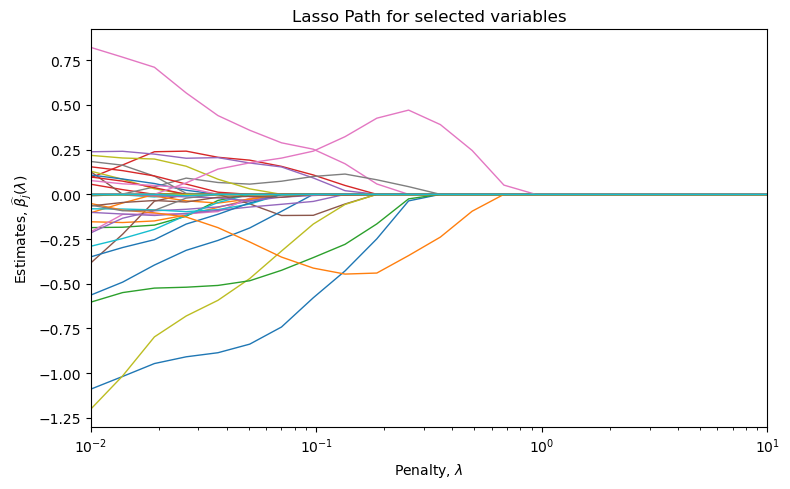

In [48]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames)



In [49]:
# Convert coefficients to array
coefs_array = np.array(coefs)
if coefs_array.ndim == 1:
    coefs_array = coefs_array.reshape(-1, 1)

n_lams, n_vars = coefs_array.shape

# Determine variable names (prefer variable_names, then Xnames)
try:
    names = list(variable_names)
except NameError:
    try:
        names = list(Xnames)
    except NameError:
        names = [f'var_{i}' for i in range(n_vars)]

# Safety: if names length mismatches, generate generic names
if len(names) != n_vars:
    names = [f'var_{i}' for i in range(n_vars)]

tol = 1e-8 # Right side max on graph
persistence = np.zeros(n_vars)
for j in range(n_vars):
    idx = np.where(np.abs(coefs_array[:, j]) > tol)[0]
    if idx.size == 0:
        persistence[j] = 0.0
    else:
        persistence[j] = float(np.max(penalty_grid[idx]))

# Exclude constant from ranking if present
const_idx = None
if 'constant' in names:
    const_idx = names.index('constant')

items = [(names[j], persistence[j]) for j in range(n_vars) if j != const_idx]
items_sorted = sorted(items, key=lambda x: x[1], reverse=True)

topk = 100
print(f"Top {topk} variables by maximum penalty where they remain non-zero (lambda_max):\n")
for name, lam in items_sorted[:topk]:
    print(f"{name:25s}  lambda_max = {lam:.3e}")

# Summary
never_selected = [names[j] for j in range(n_vars) if persistence[j] == 0 and j != const_idx]
print(f"\nNumber never selected: {len(never_selected)}")
if len(never_selected) <= 30:
    print("Never selected:", never_selected)
else:
    print("Never selected (first 30):", never_selected[:30])

# For gdp_pc_initial

# largest lambda where gdp_pc_initial is still non-zero (your persistence metric)
j = names.index("lgdp_initial")
mask = np.abs(coefs_array[:, j]) > tol
if np.any(mask):
    lam_var = float(np.max(penalty_grid[mask]))
    print(f"Max lambda with non-zero lgdp_initial: {lam_var:.6g}")
else:
    print("lgdp_initial is never selected on this grid.")




Top 100 variables by maximum penalty where they remain non-zero (lambda_max):

lh_bl                      lambda_max = 6.783e-01
goldm                      lambda_max = 4.904e-01
lgdp_initial               lambda_max = 2.563e-01
cenlong                    lambda_max = 2.563e-01
asia                       lambda_max = 2.563e-01
abslat                     lambda_max = 1.853e-01
distr                      lambda_max = 1.340e-01
suitavg                    lambda_max = 1.340e-01
kgatr                      lambda_max = 1.340e-01
precip                     lambda_max = 1.340e-01
ls_bl                      lambda_max = 1.340e-01
americas                   lambda_max = 9.686e-02
zinc                       lambda_max = 9.686e-02
suitgini                   lambda_max = 7.003e-02
gdp_initial                lambda_max = 7.003e-02
marketref                  lambda_max = 5.063e-02
tropicar                   lambda_max = 5.063e-02
distcr                     lambda_max = 5.063e-02
rough                

# Cross validation

In [50]:
# Estimate the model using LassoCV
fit_CV = LassoCV(cv=5, alphas=penalty_grid).fit(X_tilde,y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_ 
print('Penalty_CV: ', round(penalty_CV,4))

# Investigate the coefficients
coeff_CV = fit_CV.coef_
print('Coefficients: ', np.round(coeff_CV, 2))

# Investigate the selected variables
selected_mask = np.asarray(coeff_CV).ravel() != 0
selected_names = [name for name, keep in zip(Xnames, selected_mask) if keep]
print("Selected variables:", selected_names)



Penalty_CV:  0.07
Coefficients:  [-0.74 -0.   -0.   -0.   -0.   -0.12 -0.    0.   -0.32 -0.   -0.09 -0.
  0.    0.16  0.15  0.    0.29  0.07 -0.   -0.    0.   -0.   -0.42 -0.
 -0.06  0.   -0.    0.    0.   -0.   -0.   -0.35 -0.    0.   -0.02 -0.02
  0.2  -0.    0.   -0.  ]
Selected variables: ['lgdp_initial', 'distr', 'suitavg', 'suitgini', 'kgatr', 'precip', 'abslat', 'cenlong', 'asia', 'americas', 'goldm', 'zinc', 'ls_bl', 'lh_bl', 'gdp_initial']


# Mean squared error for a given penalty level


In [51]:
# Retrieve penalty and MSE
penalties_CV = fit_CV.alphas_
MSE_CV = np.mean(fit_CV.mse_path_, axis=1)

Graph code for mean squared error

In [52]:
# ...existing code...
def plot_MSE_path(penalty_grid, MSE):
    """
    Plots the mean squared error (MSE) as a function of the penalty parameter.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    MSE (array-like): The corresponding MSE values.
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Ensure inputs are numpy arrays
    penalty_grid = np.asarray(penalty_grid)
    MSE = np.asarray(MSE)

    # Plot MSE as a function of the penalty parameter
    ax.plot(penalty_grid, MSE, marker='o', markersize=3, linewidth=1)

    # Set log scale for the x-axis
    ax.set_xscale('log')
    
    # Plot minimum MSE
    min_MSE_idx = np.argmin(MSE)
    min_MSE_penalty = penalty_grid[min_MSE_idx]
    ax.axvline(x=min_MSE_penalty, linestyle='--', color='grey')

    # Place label inside the axes using axis-transform (avoids huge data-coord y)
    ax.text(min_MSE_penalty, 0.95, "Minimum MSE", rotation=90,
            transform=ax.get_xaxis_transform(), va='top', ha='right', color='grey')

    # Add labels
    ax.set_xlabel('Penalty, $\\lambda$')
    ax.set_ylabel('Mean squared error')
    ax.set_title('Mean squared error for LassoCV')

    # Tight layout and show
    fig.tight_layout()
    plt.show()
    plt.close()
# ...existing code...

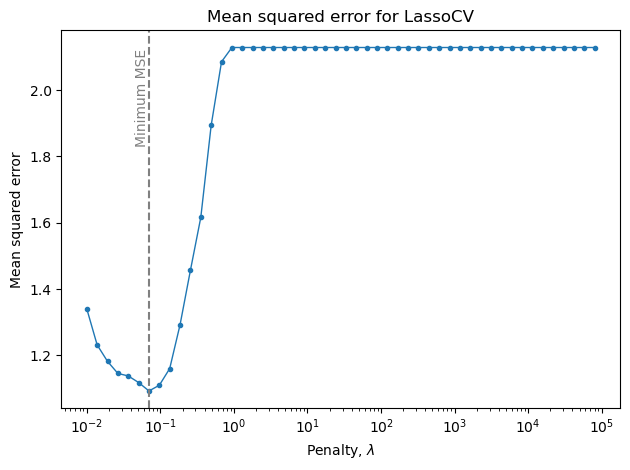

In [53]:
# Plot MSE as a function of the penalty parameter
plot_MSE_path(penalties_CV, MSE_CV)

# Adds CV vertical line to Lasso path 

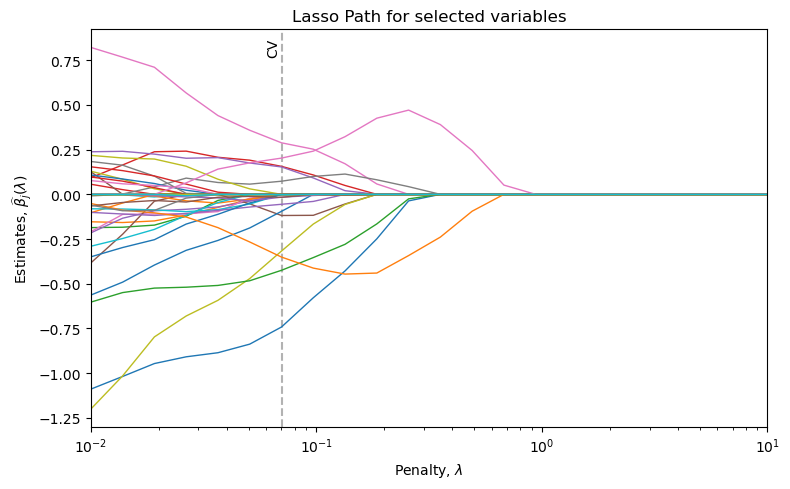

In [54]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'CV':penalty_CV})

# BRT penalty

In [55]:
X_tilde.mean(axis=0)

array([ 8.92804349e-16, -3.70074342e-17, -7.40148683e-17,  2.46716228e-17,
       -6.16790569e-18, -1.07938350e-16, -7.40148683e-17, -1.35693925e-16,
       -2.46716228e-17,  1.23358114e-16,  8.63506797e-17, -1.23358114e-17,
        0.00000000e+00,  2.46716228e-16, -1.23358114e-17, -7.40148683e-17,
        4.93432455e-17,  1.23358114e-17, -3.33066907e-16, -4.93432455e-17,
        4.93432455e-17,  2.46716228e-17,  4.93432455e-17, -2.46716228e-17,
       -2.46716228e-17, -7.40148683e-17,  3.08395285e-17,  6.16790569e-17,
       -6.16790569e-17, -4.93432455e-17,  3.02227379e-16,  1.39548866e-16,
       -4.93432455e-17,  9.86864911e-17, -6.78469626e-17,  4.31753398e-17,
        3.70074342e-17,  1.23358114e-17, -1.23358114e-17,  0.00000000e+00])

In [56]:
# BRT penalty
n,p = X_tilde.shape
sigma = np.std(y)
c = 1.1
alpha = 0.05
max_term = np.max((1/n) * np.sum((X_tilde**2),axis=0))**0.5
print(max_term)
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p))
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(X_tilde,y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT, 3))

# Selected variables - fixed indexing
selected_variables_BRT = (coeff_BRT != 0)
selected_names_BRT = [name for name, keep in zip(Xnames, selected_variables_BRT) if keep]
print('Selected variables: ', selected_names_BRT)

1.0000000000000002
Penalty_BRT:  0.6
Coefficients:  [-0.     0.     0.    -0.    -0.    -0.    -0.     0.    -0.    -0.
  0.     0.    -0.     0.     0.     0.     0.     0.     0.    -0.
 -0.    -0.    -0.    -0.    -0.     0.    -0.     0.     0.     0.
 -0.    -0.     0.     0.    -0.    -0.     0.133  0.    -0.    -0.   ]
Selected variables:  ['lh_bl']


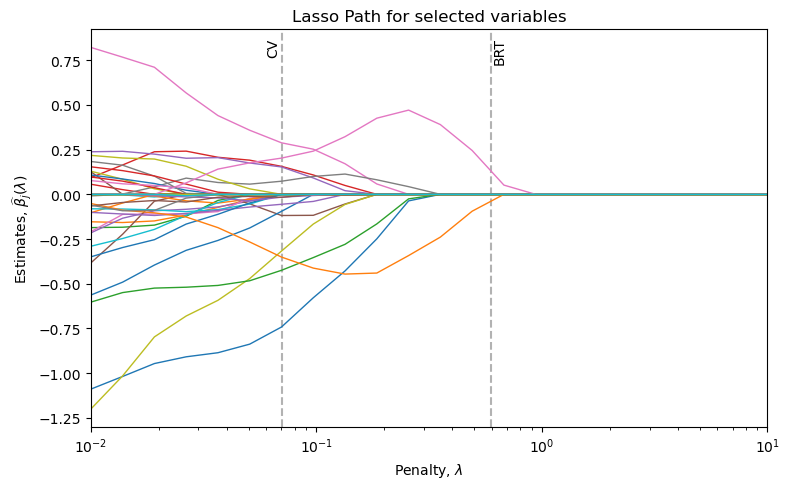

In [57]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'CV':penalty_CV, 'BRT':penalty_BRT})

# BCCH

In [58]:
# BCCH pilot penalty
n,p = X_tilde.shape
c = 1.1
alpha = 0.05
yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 2))

# Pilot estimates
#Create predicted value using Lasso 
pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

# Alternative: Manually
coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
pred = (coef_intercept + X_tilde@coeff_pilot)

# Updated penalty
eps = y - pred
epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH, 2))

# Updated estimates
fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde,y)
coeff_BCCH = fit_BCCH.coef_
print('Coefficients: ', np.round(coeff_BCCH, 2))

# Selected variables
selected_variables_BCCH = (coeff_BCCH != 0)
selected_names_BCCH = [name for name, keep in zip(Xnames, selected_variables_BCCH) if keep]
print('Selected variables: ', selected_names_BCCH)

Penalty_pilot:  1.24
Penalty BCCH:  1.24
Coefficients:  [-0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
  0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0.  0. -0. -0.
  0. -0. -0. -0.]
Selected variables:  []


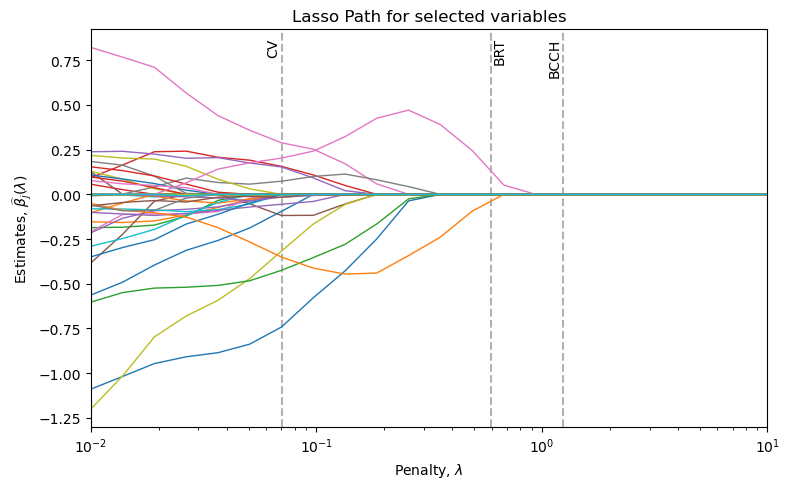

In [59]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'CV':penalty_CV, 'BRT':penalty_BRT, 'BCCH':penalty_BCCH})

# Lasso path but for polynomial and interactive terms

Create polynomial terms for X called Z

In [60]:
Z = PolynomialFeatures(2, include_bias=False).fit_transform(X)

print("Shape of Z with degree k:", Z.shape)

Z_stan = standardize(Z)
print("Shape of standardized Z:", Z_stan.shape)


Shape of Z with degree k: (72, 860)
Shape of standardized Z: (72, 860)


C:\Users\lucas\AppData\Local\Temp\ipykernel_5696\1558192923.py:4: RuntimeWarning: invalid value encountered in divide
  X_stan = (X - mu)/sigma


Standarize the Z variable

In [61]:
Z_stan = standardize(Z)
print("Shape of standardized Z:", Z_stan.shape)

Z_tilde = Z_stan

Shape of standardized Z: (72, 860)


C:\Users\lucas\AppData\Local\Temp\ipykernel_5696\1558192923.py:4: RuntimeWarning: invalid value encountered in divide
  X_stan = (X - mu)/sigma


Creates name for poly features


Removes missing observations

In [62]:
# --- set these to whatever you used to build Z/Z_tilde ---
DEGREE = 2
INCLUDE_BIAS = False
INTERACTION_ONLY = False

# Recreate a PolynomialFeatures with the same params to recover names
try:
    poly  # if you still have the original poly, this will pass
except NameError:
    poly = PolynomialFeatures(
        degree=DEGREE, include_bias=INCLUDE_BIAS, interaction_only=INTERACTION_ONLY
    )

# Determine how many original input features were used to create Z.
# Prefer the actual X array (used to compute Z). Fall back to Xnames if needed.
if 'X' in globals():
    n_input_features = np.asarray(X).shape[1]
elif 'Xnames' in globals():
    n_input_features = len(Xnames)
else:
    raise RuntimeError("Cannot determine number of input features to fit PolynomialFeatures. Define X or Xnames.")

# Fit on a dummy array with the correct n_features
poly.fit(np.empty((1, n_input_features)))

# Prepare a consistent list of base feature names of length poly.n_features_in_
if 'Xnames' in globals():
    feat_names = list(Xnames)[: poly.n_features_in_]
    if len(feat_names) < poly.n_features_in_:
        # pad with generic names if necessary
        feat_names += [f'var_{i}' for i in range(len(feat_names), poly.n_features_in_)]
else:
    feat_names = [f'var_{i}' for i in range(poly.n_features_in_)]

# Human-readable names for each column in Z/Z_tilde
# Support older sklearn versions that use get_feature_names
try:
    z_names = poly.get_feature_names_out(feat_names)
except AttributeError:
    z_names = poly.get_feature_names(feat_names)

# Find and report non-finite columns
mask_cols = np.isfinite(Z_tilde).all(axis=0)
dropped_idx = np.flatnonzero(~mask_cols)
dropped_names = [z_names[i] for i in dropped_idx]

print(f"Removed {len(dropped_idx)} columns with NaN/Inf.")
if dropped_idx.size:
    print("Dropped variables (Z-index → name):")
    for i, n in zip(dropped_idx, dropped_names):
        print(f" - Z{i} → {n}")

# (optional) actually drop them + keep surviving names
Z_tilde = Z_tilde[:, mask_cols]
Z_names_kept = [z_names[i] for i in np.flatnonzero(mask_cols)]


Removed 15 columns with NaN/Inf.
Dropped variables (Z-index → name):
 - Z653 → landlock oceania
 - Z661 → landlock goldm
 - Z662 → landlock iron
 - Z663 → landlock silv
 - Z664 → landlock zinc
 - Z671 → africa asia
 - Z672 → africa oceania
 - Z673 → africa americas
 - Z682 → africa silv
 - Z690 → asia oceania
 - Z691 → asia americas
 - Z698 → asia goldm
 - Z700 → asia silv
 - Z708 → oceania americas
 - Z713 → oceania malfal


In [63]:
# Estimate the model using LassoCV
fit_CV_Z = LassoCV(cv=5, alphas=penalty_grid).fit(Z_tilde,y)

# Investigate the penalty
penalty_CV_Z = fit_CV_Z.alpha_ 
print('Penalty_CV_Z: ', round(penalty_CV_Z,4))

# Investigate the coefficients
coeff_CV_Z = fit_CV_Z.coef_
print('Coefficients for Z: ', np.round(coeff_CV_Z, 2))

# Investigate the selected variables
selected_mask = np.asarray(coeff_CV_Z).ravel() != 0
selected_names = [name for name, keep in zip(Z_names_kept, selected_mask) if keep]
print("Selected variables:", selected_names)



d:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e-02, tolerance: 9.911e-03
  model = cd_fast.enet_coordinate_descent(
d:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.699e-02, tolerance: 1.375e-02
  model = cd_fast.enet_coordinate_descent(
d:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.741e-02, toleranc

Penalty_CV_Z:  0.0969
Coefficients for Z:  [-0.07 -0.    0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.    0.    0.    0.    0.    0.    0.   -0.   -0.    0.    0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.   -0.    0.    0.
 -0.   -0.   -0.   -0.   -0.   -0.    0.   -0.   -0.   -0.   -0.05 -0.
 -0.   -0.17 -0.   -0.   -0.    0.    0.    0.   -0.    0.    0.   -0.
 -0.   -0.    0.    0.   -0.   -0.    0.   -0.   -0.   -0.   -0.   -0.
  0.   -0.    0.    0.   -0.   -0.13 -0.17 -0.   -0.    0.   -0.    0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.1  -0.    0.    0.   -0.   -0.
  0.   -0.   -0.   -0.    0.   -0.    0.   -0.   -0.   -0.   -0.    0.
  0.   -0.   -0.    0.   -0.    0.   -0.   -0.   -0.   -0.   -0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -0.   -0.    0.   -0.    0.    0.    0.    0.   -0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 -0.    0.    0.    0.    0.   -0.

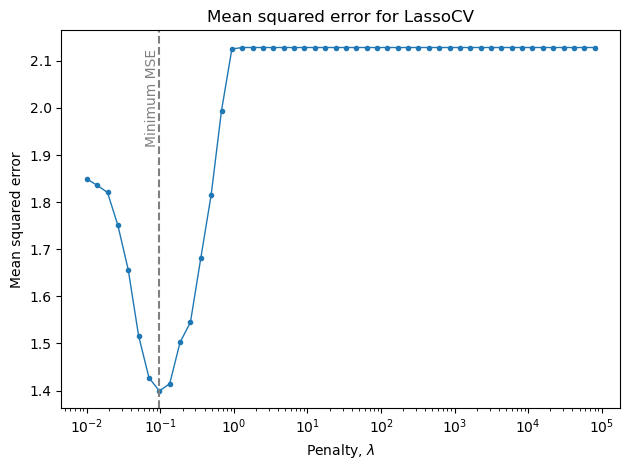

In [64]:
# Retrieve penalty and MSE
penalties_CV_Z = fit_CV_Z.alphas_                  # vector of alphas
MSE_CV = np.mean(fit_CV_Z.mse_path_, axis=1)     # vector of MSEs

# Plot
plot_MSE_path(penalties_CV_Z, MSE_CV)


In [65]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num = 50)

coefs_Z=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(Z_tilde,y) 
    coefs_Z.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs_Z

d:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-02, tolerance: 1.467e-02
  model = cd_fast.enet_coordinate_descent(
d:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e-02, tolerance: 1.467e-02
  model = cd_fast.enet_coordinate_descent(


CV lasso path

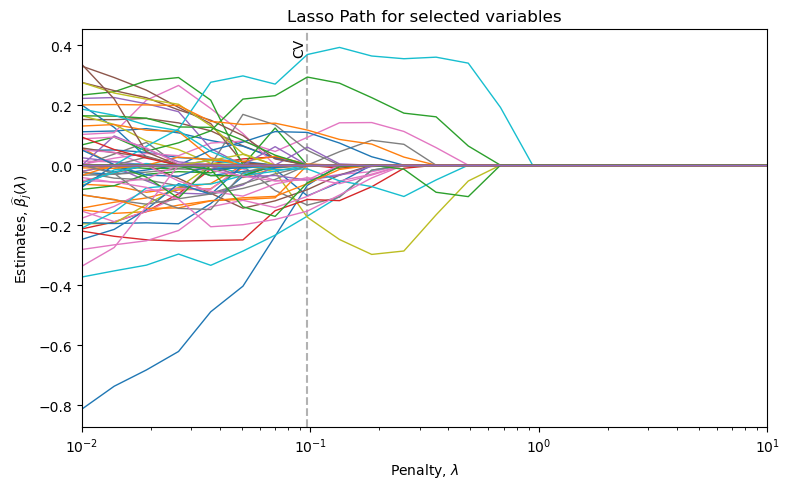

In [66]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs_Z, Z_names_kept, vlines={'CV':penalty_CV_Z})

Variables that have the highest penalty bound

In [67]:
# Convert coefficients to array
coefs_array = np.array(coefs_Z)
if coefs_array.ndim == 1:
    coefs_array = coefs_array.reshape(-1, 1)

n_lams, n_vars = coefs_array.shape

# Determine variable names (prefer variable_names, then Z_names_kept)
try:
    names = list(variable_names)
except NameError:
    try:
        names = list(Z_names_kept)
    except NameError:
        names = [f'var_{i}' for i in range(n_vars)]

# Safety: if names length mismatches, generate generic names
if len(names) != n_vars:
    names = [f'var_{i}' for i in range(n_vars)]

tol = 1e-8 # Right side max on graph
persistence = np.zeros(n_vars)
for j in range(n_vars):
    idx = np.where(np.abs(coefs_array[:, j]) > tol)[0]
    if idx.size == 0:
        persistence[j] = 0.0
    else:
        persistence[j] = float(np.max(penalty_grid[idx]))

# Exclude constant from ranking if present
const_idx = None
if 'constant' in names:
    const_idx = names.index('constant')

items = [(names[j], persistence[j]) for j in range(n_vars) if j != const_idx]
items_sorted = sorted(items, key=lambda x: x[1], reverse=True)

topk = 10
print(f"Top {topk} variables by maximum penalty where they remain non-zero (lambda_max):\n")
for name, lam in items_sorted[:topk]:
    print(f"{name:25s}  lambda_max = {lam:.3e}")

# Summary
never_selected = [names[j] for j in range(n_vars) if persistence[j] == 0 and j != const_idx]
print(f"\nNumber never selected: {len(never_selected)}")
if len(never_selected) <= 30:
    print("Never selected:", never_selected)
else:
    print("Never selected (first 30):", never_selected[:30])

Top 10 variables by maximum penalty where they remain non-zero (lambda_max):

cenlong asia               lambda_max = 6.783e-01
lgdp_initial pop_growth    lambda_max = 4.904e-01
area asia                  lambda_max = 4.904e-01
pop_growth^2               lambda_max = 4.904e-01
suitavg asia               lambda_max = 3.545e-01
africa yellow              lambda_max = 3.545e-01
elevstd area               lambda_max = 2.563e-01
abslat malfal              lambda_max = 2.563e-01
asia pprotest              lambda_max = 2.563e-01
lgdp_initial distcr        lambda_max = 1.853e-01

Number never selected: 751
Never selected (first 30): ['marketref', 'dem', 'demreg', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim', 'yellow', 'malfal', 'oilres', 'goldm']


# BRT

In [68]:
# BRT penalty
n,p = Z_tilde.shape
sigma = np.std(y)
c = 1.1
alpha = 0.05
max_term = np.max((1/n) * np.sum((Z_tilde**2),axis=0))**0.5
print(max_term)
penalty_BRT_Z = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p))
print('Penalty_BRT: ', round(penalty_BRT_Z,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT_Z).fit(Z_tilde,y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT, 3))

# Selected variables - fixed indexing
selected_variables_BRT = (coeff_BRT != 0)
selected_names_BRT = [name for name, keep in zip(Z_names_kept, selected_variables_BRT) if keep]
print('Selected variables: ', selected_names_BRT)

1.0000000000000036
Penalty_BRT:  0.74
Coefficients:  [-0.     0.     0.     0.    -0.    -0.    -0.    -0.     0.    -0.
 -0.     0.     0.    -0.     0.     0.     0.     0.     0.     0.
 -0.    -0.     0.     0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.     0.    -0.     0.     0.     0.    -0.    -0.     0.
 -0.     0.     0.     0.    -0.    -0.    -0.    -0.     0.    -0.
 -0.    -0.     0.    -0.     0.     0.     0.     0.     0.     0.
 -0.    -0.     0.     0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.     0.    -0.     0.     0.     0.    -0.    -0.     0.
  0.     0.     0.     0.     0.    -0.    -0.     0.     0.     0.
 -0.     0.     0.     0.    -0.     0.     0.     0.     0.    -0.
 -0.     0.     0.    -0.     0.    -0.    -0.     0.    -0.    -0.
  0.     0.    -0.     0.     0.     0.     0.    -0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.    -0.   

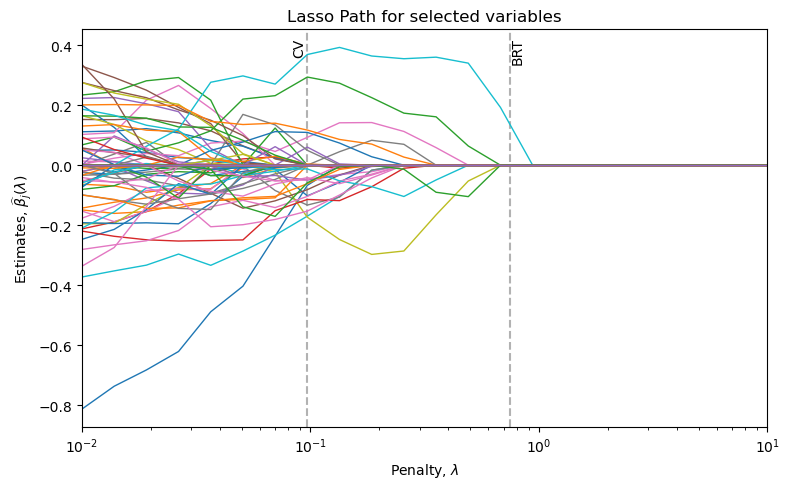

In [69]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs_Z, Z_names_kept, vlines={'CV':penalty_CV_Z, 'BRT':penalty_BRT_Z})

# BBCH

In [70]:
# BCCH pilot penalty
n,p = Z_tilde.shape
c = 1.1
alpha = 0.05
yXscale = (np.max((Z_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 2))

# Pilot estimates
#Create predicted value using Lasso 
pred = Lasso(alpha=penalty_pilot).fit(Z_tilde,y).predict(Z_tilde)

# Alternative: Manually
coeff_pilot = Lasso(alpha=penalty_pilot).fit(Z_tilde,y).coef_
coef_intercept = Lasso(alpha=penalty_pilot).fit(Z_tilde,y).intercept_
pred = (coef_intercept + Z_tilde@coeff_pilot)

# Updated penalty
eps = y - pred
epsXscale = (np.max((Z_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH_Z = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH_Z, 2))

# Updated estimates
fit_BCCH_Z = Lasso(alpha=penalty_BCCH_Z).fit(Z_tilde,y)
coeff_BCCH_Z = fit_BCCH_Z.coef_
print('Coefficients: ', np.round(coeff_BCCH_Z, 2))

# Selected variables
selected_variables_BCCH = (coeff_BCCH_Z != 0)
selected_names_BCCH = [name for name, keep in zip(Z_names_kept, selected_variables_BCCH) if keep]
print('Selected variables: ', selected_names_BCCH)

Penalty_pilot:  2.78
Penalty BCCH:  2.78
Coefficients:  [-0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.
  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0. -0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0.
  0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
 -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0. -0. -0.  0.
  0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.
  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.
  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0. -0.

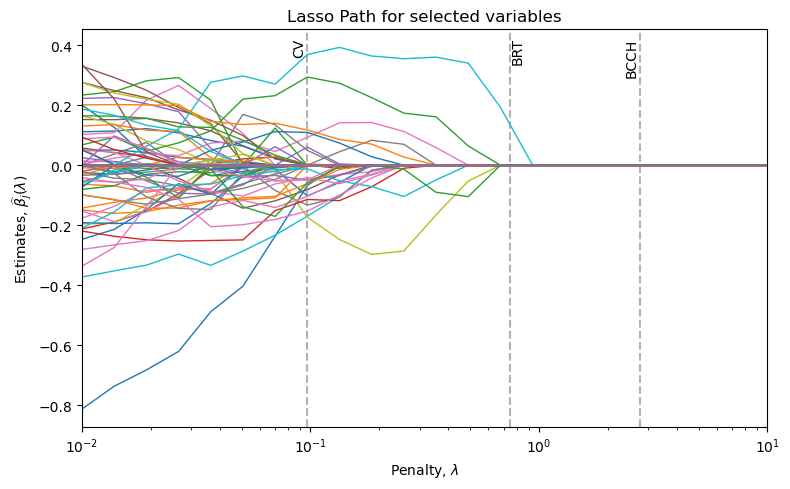

In [71]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs_Z, Z_names_kept, vlines={'CV':penalty_CV_Z, 'BRT':penalty_BRT_Z, 'BCCH':penalty_BCCH_Z})

# ESTIMATIONS AND RESULTS

# Reset everything and redo data cleaning

In [72]:
%reset -f

In [73]:
import pandas as pd 
import numpy as np 
import numpy.linalg as la
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

# Indlæser data og databehandler på samme måde som før

In [74]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Defines variable groups

In [75]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage'] # Diseases
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

# Variables we use
# Institutions, geography, religion, danger (health), resources, education, pop growth

# Code job for Lucas
# Use variables choosen
# Graph Lasso with different penalty levels
# Lasso with CV, BRT and BCCH at difference penalty levels like in week 4 exercise
# Use BRT and BCCH optimal penalty level and use dobbel lasso and post dobbelt lasso.



# Removes countries with missing growth and initial gdp

In [76]:
from datetime import datetime

# ---- configuration ----
id_col = 'code'
cols_to_check = ['gdp_growth', 'lgdp_initial']

# ---- identify rows to remove / keep ----
missing_mask = dat[cols_to_check].isnull().any(axis=1)
removed = dat.loc[missing_mask].copy()
kept = dat.loc[~missing_mask].copy()
print(f"Rows with missing {cols_to_check} ({removed.shape[0]} rows) have been removed.")
print(f"Remaining data has {kept.shape[0]} rows.")


Rows with missing ['gdp_growth', 'lgdp_initial'] (112 rows) have been removed.
Remaining data has 102 rows.


# Defines variables

In [77]:
# Keep only interesting variables
# Combining all variables we want to use
vs = []
vs.extend(vv_all['institutions'])  # Institutional variables
vs.extend(vv_all['geography'])     # Geographic variables
vs.extend(vv_all['religion'])      # Religious variables
vs.extend(vv_all['danger'])        # Health/disease variables
vs.extend(vv_all['resources'])     # Natural resource variables
vs.extend(vv_educ)                 # Education variables
vs.extend(['pop_growth'])          # Population growth
vs.extend(['lgdp_initial'])        # Log gdp initial
vs.extend(['pdiv'])              # Genetic diversity

# Add our main variables of interest
main_var = ['gdp_pc_initial']
all_vars = main_var + vs

# Only remove countries with missing values in our chosen variables
complete_cases = dat[all_vars].notnull().all(axis=1)
kept = dat[complete_cases].copy()


# Prepare data for Lasso
y = kept['gdp_growth'].values.reshape((-1,1)) * 100.0  # Convert to percentage
Z_basic = kept[vs].values       # All variables except the dependent
d = kept['gdp_pc_initial'].values # Our beta variable

Xnames = list(kept[['gdp_pc_initial'] + vs].columns)

# Print dimensions of our matrices
print(f'Z_basic matrix shape: {Z_basic.shape}')
print(f'y vector shape: {y.shape}')

# Display number of regressors
#print("The number of regressors in Z is {}".format(Z.shape[1]))

# Verify no missing values remain in our variables of interest
print("\nMissing values after filtering:")
print(kept[all_vars].isnull().sum())


Z_basic matrix shape: (74, 42)
y vector shape: (74, 1)

Missing values after filtering:
gdp_pc_initial    0
marketref         0
dem               0
demCGV            0
demBMR            0
demreg            0
tropicar          0
distr             0
distcr            0
distc             0
suitavg           0
temp              0
suitgini          0
elevavg           0
elevstd           0
kgatr             0
precip            0
area              0
abslat            0
cenlong           0
area_ar           0
rough             0
landlock          0
africa            0
asia              0
oceania           0
americas          0
pprotest          0
pcatholic         0
pmuslim           0
yellow            0
malfal            0
uvdamage          0
oilres            0
goldm             0
iron              0
silv              0
zinc              0
ls_bl             0
lh_bl             0
pop_growth        0
lgdp_initial      0
pdiv              0
dtype: int64


# Removes 3 variables with multicolirations

In [78]:
# Drop unwanted variables from the kept DataFrame and update related arrays/lists
cols_to_drop = ['uvdamage', 'demCGV', 'demBMR']
# We drop these, as they are very correlated with other variables, leading to multicollinearity issues.

# Drop from kept if present
for c in cols_to_drop:
    if c in kept.columns:
        kept.drop(columns=c, inplace=True)

# Remove from vs (controls) if present
vs = [v for v in vs if v not in cols_to_drop]

# Rebuild X, d, Z and Xnames consistent with the dropped variables
Z_basic = kept[vs].values
d = kept['lgdp_initial'].values

# Defines X
X = np.column_stack((d, Z_basic))
Xnames = list(kept[['lgdp_initial'] + vs].columns)

# Also makes polynomial for Z
Z = PolynomialFeatures(2, include_bias=False).fit_transform(Z_basic)
print("Shape of Z with degree k:", Z.shape)
X_pol = np.column_stack((d, Z))
Xnames_pol = ['lgdp_initial'] + [f'Z{i}' for i in range(Z.shape[1])]

# Find N
N = X.shape[0]
N_pol = X_pol.shape[0]

# Update variable name lists if they exist in the namespace
for name in ('variable_names', 'var_names', 'var_names_reduced', 'vars_no_const'):
    if name in globals():
        globals()[name] = [v for v in globals()[name] if v not in cols_to_drop]

print("Dropped columns:", [c for c in cols_to_drop if c not in kept.columns])
print("X shape:", X.shape)
print("d shape:", d.shape)

print("First X names:", Xnames[:10])
print("First X_pol names (polynomial):", Xnames_pol[:10])

Shape of Z with degree k: (74, 819)
Dropped columns: ['uvdamage', 'demCGV', 'demBMR']
X shape: (74, 40)
d shape: (74,)
First X names: ['lgdp_initial', 'marketref', 'dem', 'demreg', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp']
First X_pol names (polynomial): ['lgdp_initial', 'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8']


# Makes Standarization

In [79]:
# Create a function for standardizing
def standardize(X):

    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_stan = standardize(X)
X_pol_stan = standardize(X_pol)
Z_stan = standardize(Z)
d_stan = standardize(d)

C:\Users\lucas\AppData\Local\Temp\ipykernel_5696\3992268028.py:4: RuntimeWarning: invalid value encountered in divide
  X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)


# 1: OLS

In [80]:
# Add a constant to X
xx = np.column_stack((np.ones(N),X))

# Reshape y
yy = np.array(y).reshape(-1,1)

# Calculate OLS estimate
coefs_OLS = la.inv(xx.T@xx)@xx.T@yy
alpha_OLS = coefs_OLS[1][0]

# Calculate residuals
res_OLS = yy - xx@coefs_OLS

# Display alpha
print("alpha_OLS = ",alpha_OLS.round(2))

alpha_OLS =  nan


# Double Post Lasso